Lydia Holley

lholley4@uncc.edu

Assignment 3

In [1]:
# import all the needed packages
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f
import matplotlib.patches as mpatches

1. Linear regression

    Use x and y in linear regression test data.csv for writing and debugging your code. For both of the Python classes you implement, return the intercept θ0, the coefficient θ1, the R2 value, the F statistic and the associated p-value.

(a) (20 points) Implement a Python class to do linear regression using the analytical solution to
least-squared problems.

In [2]:
# create the class for analytical SLR
class analytical_slr:
    
    # initialize the necesary data
    def __init__(self,data,standardize=False):
        
        self.data = data
        self.standardize = standardize
        self.standardized = None
        self.X = None
        self.Y = None
        self.n = None
        self.b1hat = None
        self.sstot = None
        self.ssreg = None
        self.sserr = None
        self.mstot = None
        self.msreg = None
        self.mserr = None
        self.Fstat = None
        self.R2 = None
        self.p_value = None
    
    # standardize if desired
    # or get the means and separate x y data
    # get size of data n
    def fit(self):

        data_mean = np.mean(self.data,axis=0)
        std_dev = np.std(self.data,axis=0)
        
        # if user requested standardized
        if self.standardize == True:
            self.X = (self.data[:,0] - data_mean[0])/std_dev[0]
            self.Y = (self.data[:,1] - data_mean[1])/std_dev[1]
            self.data = np.vstack((self.X,self.Y)).T
        
        # if user wants to use non standardized data
        elif self.standardize == False:
            self.X = self.data[:,0]
            self.Y = self.data[:,1]
        
        self.xbar = data_mean[0]
        self.ybar = data_mean[1]
        
        self.n = len(self.data)

    # in this function, find all the necesary data and return the asked for values
    def predict(self):
        
        # first use cov and var to get the beta 1 hat
        cov_matrix = np.cov(self.data, rowvar=False)
        covariance = float(cov_matrix[1:,:1])
        variance = float(cov_matrix[0,0])
        self.b1hat = covariance/variance
        
        # find beta 0 hat and use the betas to find yhat
        self.b0hat = self.ybar - (self.b1hat*self.xbar)        
        self.yhat = self.b0hat + (self.b1hat*self.X)
        
        # find the sum of squares data
        self.sstot = np.sum((self.Y-self.ybar)**2)       
        self.ssreg = np.sum((self.yhat-self.ybar)**2)        
        self.sserr = np.sum((self.Y-self.yhat)**2)
        
        # find the mean sum of squares data
        self.mstot = self.sstot/(self.n - 1)        
        self.msreg = self.ssreg/1        
        self.mserr = self.sserr/(self.n - 2)
        
        # find F statistic, R2, and P values
        self.Fstat = self.msreg/self.mserr        
        self.R2 = self.ssreg/self.sstot       
        self.p_value = f.sf(self.Fstat, 1, (self.n - 2))
        
        # return answers
        answers = print("Intercept: " + str(self.b0hat) + "\nCoefficient: " + str(self.b1hat) + "\nR2: " + str(self.R2) + "\nF Statistic: " + str(self.Fstat) + "\nP-value: " + str(self.p_value))
        
        return answers


In [3]:
# read in the dataset, only need x and y for this
data = pd.read_csv('linear_regression_test_data.csv',index_col = 0)
data = data[['x','y']]
data = data.to_numpy()

In [4]:
# call the class and the functions within to get requested data
test = analytical_slr(data)
fit = test.fit()
predict = test.predict()

Intercept: 0.024525025871305117
Coefficient: 1.934005885001058
R2: 0.9292357328496265
F Statistic: 236.36566680963753
P-value: 8.52900501738634e-12


In [5]:
# Answers
# Intercept: 0.024525025871305117
# Coefficient: 1.934005885001058
# R2: 0.9292357328496265
# F Statistic: 236.36566680963753
# P-value: 8.52900501738634e-12

(b) (30 points) Implement a Python class for gradient descent-based linear regression. Use ∆J =
0.00001 as the stopping criterion.

In [6]:
# create the class for gradient descent-based SLR
class gradient_slr:
    
    # initialize necesary data
    def __init__(self, data, theta0=0, theta1=0, alpha=0.05, standardize=False):

        self.data = data
        self.theta0 = theta0
        self.theta1 = theta1
        self.alpha = alpha
        self.standardize = standardize
        self.X = None
        self.Y = None
        self.xbar = None
        self.ybar = None
        self.standardized = None
        self.iterations = None
        self.cost_new = None
        self.cost_init = None
        self.R2 = None
        self.Fstat = None
        self.p_value = None
        self.sstot = None
        self.ssreg = None
        self.sserr = None
        self.mstot = None
        self.msreg = None
        self.mserr = None
        self.Fstat = None
    
    # standardize if desired
    # or get the means and separate x y data
    # get size of data n    
    def fit(self):
        
        data_mean = np.mean(self.data,axis=0)
        std_dev = np.std(self.data,axis=0)
        
        # if user requested standardized
        if self.standardize == True:
            self.X = (self.data[:,0] - data_mean[0])/std_dev[0]
            self.Y = (self.data[:,1] - data_mean[1])/std_dev[1]
            self.data = np.vstack((self.X,self.Y)).T
        
        # if user requested not standardized
        elif self.standardize == False:
            self.X = self.data[:,0]
            self.Y = self.data[:,1]
        
        self.xbar = data_mean[0]
        self.ybar = data_mean[1]
        
        self.n = len(self.data)

    # in this function, find all the necesary data and return the asked for values    
    def predict(self):
        
        stop = False
        iteration = 0
         
        while stop == False:

            #keep track of iterations
            iteration += 1
                
            #find initial cost
            ri_init = self.theta0 + (self.theta1*self.X) - self.Y

            r2_init = np.sum(ri_init**2)

            cost_init = r2_init/(2*self.n)

            #find step values
            step0 = np.sum(ri_init)/self.n

            step1 = np.sum(ri_init*self.X)/self.n

            #find new thetas based on steps
            self.theta0 -= (self.alpha*step0)

            self.theta1 -= (self.alpha*step1)
            
            #find new cost
            ri_new = self.theta0 + (self.theta1*self.X) - self.Y

            r2_new = np.sum(ri_new**2)

            cost_new = r2_new/(2*self.n) 
            
            #find cost difference
            cost_diff = cost_init - cost_new
            
            #if cost difference meets criteria, store data and move on
            if cost_diff <= 0.00001:
                self.iterations = iteration
                self.cost_new = cost_new
                self.cost_init = cost_init
                stop = True
        
        #find hypothesis value
        self.hypothesis = self.theta0 + (self.theta1*self.X)
        
        #find sum of squares values
        self.sstot = np.sum((self.Y-self.ybar)**2)        
        self.ssreg = np.sum((self.hypothesis-self.ybar)**2)       
        self.sserr = np.sum((self.Y-self.hypothesis)**2)
        
        #find mean sum of squares values
        self.mstot = self.sstot/(self.n - 1)        
        self.msreg = self.ssreg/1       
        self.mserr = self.sserr/(self.n - 2)
        
        #find F statistic, R2, and P values
        self.Fstat = self.msreg/self.mserr       
        self.R2 = self.ssreg/self.sstot        
        self.p_value = f.sf(self.Fstat, 1, (self.n - 2))
        
        #return answers
        return f'Intercept: {self.theta0}', f'Coefficient: {self.theta1}', f'R2: {self.R2}', f'F Statistics: {self.Fstat}', f'P-Value: {self.p_value}', f'Number of iterations: {self.iterations}'
            


In [7]:
#read in the dataset
data2 = pd.read_csv('linear_regression_test_data.csv',index_col = 0)
data2 = data2[['x','y']]
data2 = data2.to_numpy()

In [8]:
#call the class and functions to get requested data
test2 = gradient_slr(data2)
fit2 = test2.fit()
predict2 = test2.predict()

In [9]:
predict2

('Intercept: 0.038678951631553125',
 'Coefficient: 1.9245430996889048',
 'R2: 0.9201897516236642',
 'F Statistics: 233.908575686262',
 'P-Value: 9.3107035206637e-12',
 'Number of iterations: 100')

In [10]:
# Answers
# ('Intercept: 0.038678951631553125',
#  'Coefficient: 1.9245430996889048',
#  'R2: 0.9201897516236642',
#  'F Statistics: 233.908575686262',
#  'P-Value: 9.3107035206637e-12',
#  'Number of iterations: 100')

In [11]:
# item of note:
# if I change the diff_cost cutoff to 0.00000001, the numbers are much closer to the analytical slr

# ('Intercept: 0.024979014449902477',
#  'Coefficient: 1.9337238230452056',
#  'R2: 0.9289647335775363',
#  'F Statistics: 236.29657866360188',
#  'P-Value: 8.549961480400911e-12',
#  'Number of iterations: 185')


---------

2. PCA and linear regression

In [12]:
#input my pca class
class myPCA:
    
    def __init__(self, data, num_components):
        # two inputs, one is the data and the other is the number of PCAs desired
        # I found this to be the easiest way to call the class

        self.data = data
        self.num_components = num_components
        
        # these following values need to be initialized so they can be stored as part of the class
        # this makes it possible to call on these values even from different class methods
        self.eigenvectors = None
        self.eigenvalues = None
        self.data_mean = None
        self.new_data = None
        self.projected = None
        self.pcnt_var = None
        self.variance = None
        
    def my_fit(self):
        # do mean centering
        self.data_mean = np.mean(self.data,axis=0)
        self.new_data = self.data - self.data_mean
        
        # compute covariance matrix using numpy.cov()
        # for np.cov the columns need to be samples, so transpose the data
        cov_matrix = np.cov(self.new_data.transpose()) 
        
        # perform eigendecomposition using np.linalg.eig()
        eigenvalues,eigenvectors = np.linalg.eigh(cov_matrix)
        
        # sort eigenvectors and eigenvalues for the PCA
        eigenvectors = eigenvectors.transpose()
        index = np.argsort(eigenvalues)[::-1]
        eigenvalues_sorted = eigenvalues[index]
        eigenvectors_sorted = eigenvectors[index]
        
        #store first num_components eigenvectors and eigenvalues
        self.eigenvectors = eigenvectors_sorted[0:self.num_components]
        self.eigenvalues = eigenvalues_sorted[0:self.num_components]
        
    def my_transform(self):
        #project the data onto the principle components of the number of components
        self.projected = np.dot(self.new_data,self.eigenvectors.transpose())
        return self.projected
    
    def my_fit_transform(self):
        # combine fit and transform methods to be able to do all at once
        # do mean centering
        self.data_mean = np.mean(self.data,axis=0)
        self.new_data = self.data - self.data_mean
        
        # compute covariance matrix using numpy.cov()
        #row = 1 sample, column = feature
        cov_matrix = np.cov(self.new_data.transpose()) #this function needs column to be a sample
        
        # perform eigendecomposition
        eigenvalues,eigenvectors = np.linalg.eigh(cov_matrix)
        
        # sort eigenvectors for the PCA
        eigenvectors = eigenvectors.transpose()
        index = np.argsort(eigenvalues)[::-1]
        eigenvalues_sorted = eigenvalues[index]
        eigenvectors_sorted = eigenvectors[index]
        
        #store first n eigenvectors and eigenvalues
        self.eigenvectors = eigenvectors_sorted[0:self.num_components]
        self.eigenvalues = eigenvalues_sorted[0:self.num_components]
        
        #project our data
        self.projected = np.dot(self.new_data,self.eigenvectors.transpose())
        return self.projected
    
    def my_var(self):
        # return the variance
        self.variance = np.var(self.projected, axis=0)
        return f'Variance Explained: {list(self.variance)}'
    
    def my_pct_var(self):
        # return the percent variance explained by each PC by finding percent of total eigenvalues
        total_eigenvalues = sum(self.eigenvalues)
        pct_variance = []
        for i in self.eigenvalues:
            pctVar = (i/total_eigenvalues)*100
            pct_variance.append(pctVar)
            
        self.pcnt_var = pct_variance           
        return f'Percent Variance Explained: {pct_variance}'
    
    def my_scores(self):
        # return the scores, which is the data projected onto the principle components
        return self.projected
    
    def my_loadings(self):
        # return the loadings, which is the eigenvectors
        return self.eigenvectors

In [13]:
#read in the dataset
data3 = pd.read_csv('linear_regression_test_data.csv',index_col = 0)
data3_pca = data3[['x','y']]
data3_pca = data3_pca.to_numpy()

data3 = data3.to_numpy()

In [65]:
# call pca class for just one principal component

pca = myPCA(data3_pca,1)
pcafit = pca.my_fit()
projected = pca.my_transform()
pctVar = pca.my_pct_var()
var = pca.my_var()
loadings = pca.my_loadings()
scores = pca.my_scores()


array([[0.43814047, 0.89890652]])

(a) (20 points) The data in linear regression test data.csv contains x, y, and y−theoretical.
Perform PCA on x and y using your own PCA class. Plot y vs x, y-theoretical vs x, and the PC1
axis in the same plot.

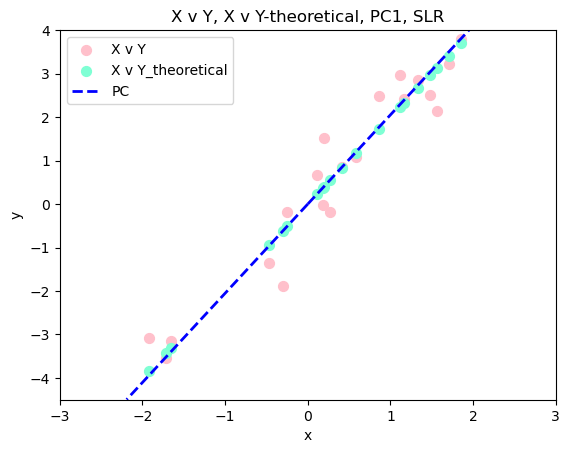

In [96]:
# plotting the data projected on PC1

plt.figure()

plt.scatter(data3[:,0], data3[:,1], color = 'pink', label='X v Y', s=50)
plt.scatter(data3[:,0], data3[:,2], color = 'aquamarine', label='X v Y_theoretical', s=50)
plt.plot([0, -5*loadings[0,0]], [0, -5*loadings[0, 1]], color='blue', linewidth=2, linestyle='dashed')
plt.plot([0, 5*loadings[0,0]], [0, 5*loadings[0, 1]], color='blue', linewidth=2, label='PC', linestyle='dashed')

plt.xlabel('x')
plt.ylabel('y')
plt.title('X v Y, X v Y-theoretical, PC1, SLR')

plt.legend()
plt.xlim([-3, 3])  
plt.ylim([-4.5, 4]) 
plt.show()


(b) (30 points) Perform linear regression on x and y with x being the independent variable and y
being the dependent variable. Plot the regression line in the same plot as you obtained in (1).
Compare the PC1 axis and the regression line obtained above. Are they very different or very
similar? Could you explain why this happens?

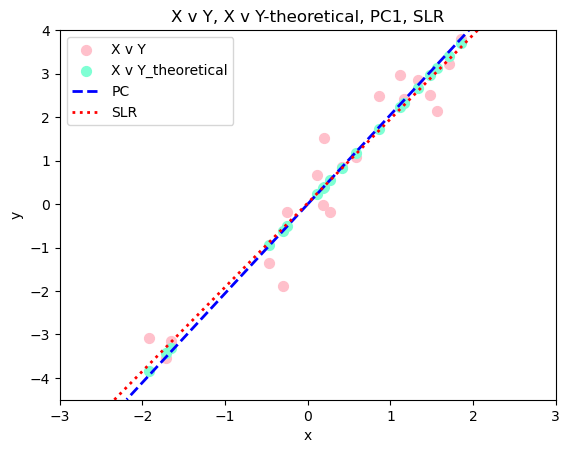

In [97]:
# plotting linear regression

plt.figure()

plt.scatter(data3[:,0], data3[:,1], color = 'pink', label='X v Y', s=50)
plt.scatter(data3[:,0], data3[:,2], color = 'aquamarine', label='X v Y_theoretical', s=50)
plt.plot([0, -5*loadings[0,0]], [0, -5*loadings[0, 1]], color='blue', linewidth=2, linestyle='dashed')
plt.plot([0, 5*loadings[0,0]], [0, 5*loadings[0, 1]], color='blue', linewidth=2, label='PC', linestyle='dashed')
plt.axline((0, test.b0hat), slope=test.b1hat, color='red', linewidth=2, label='SLR', linestyle='dotted')

plt.xlabel('x')
plt.ylabel('y')
plt.title('X v Y, X v Y-theoretical, PC1, SLR')

plt.legend()
plt.xlim([-3, 3])  
plt.ylim([-4.5, 4]) 
plt.show()


The PC1 axis and regression line are very similar. PCA finds the line with the least orthongal distance from the points with respect to the model line and linear regression finds the line with the least distance with respect to the axis. Since both are finding lines of fit with the same data, it follows the lines would be similar, but because they are using different frameworks they have the noticable differences.